In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [3]:
print("FlashAttention available:", torch.backends.cuda.flash_sdp_enabled())

FlashAttention available: True


In [5]:
data = pd.read_csv('data.csv').to_numpy()
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [6]:
train_length = round(len(data) * 0.8)

train_data = torch.tensor(data[:train_length], dtype=torch.float32)
test_data = torch.tensor(data[train_length:], dtype=torch.float32)
all_data = torch.tensor(data, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=16, shuffle=False)
all_loader = DataLoader(TensorDataset(all_data), batch_size=16, shuffle=True)

In [81]:
class TransformerAE(nn.Module):
    def __init__(self, input_dim, seq_length, d_model, nhead=4, num_layers=1, bottleneck_dim=48):
        super(TransformerAE, self).__init__()
        
        self.seq_length = seq_length
        self.d_model = d_model
        
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.bottleneck = nn.Linear(seq_length * d_model, bottleneck_dim)
        self.bottleneck_decoder = nn.Linear(bottleneck_dim, seq_length * d_model)
        
        decoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=num_layers)
        
        self.output_proj = nn.Linear(d_model, input_dim)
        
    def encode(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = x.flatten(start_dim=1)
        x = self.bottleneck(x)
        return x
    
    def decode(self, x):
        x = self.bottleneck_decoder(x)
        x = x.unflatten(1, (self.seq_length, self.d_model))
        x = self.decoder(x)
        x = self.output_proj(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
        

In [89]:
model = TransformerAE(input_dim=48, d_model=48, seq_length=31).to(device)

In [90]:
k = 0
for param in model.parameters():
    if param.requires_grad:
        k += torch.prod(torch.tensor(param.size()))
print(f'Model has {k} trainable parameters')

Model has 565696 trainable parameters


In [91]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [92]:
all_train_losses = []
train_losses = []
test_losses = []

In [94]:
epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in train_loader:
        
        batch = batch[0].unsqueeze(1).view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        all_train_losses.append(loss.item())
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
    train_losses.append(avg_loss)
    
    model.eval()
    avg_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].unsqueeze(1).view(-1, 31, 48).to(device)
            preds = model(batch)
            loss = criterion(preds, batch)
            
            avg_test_loss += loss.item()
    avg_test_loss /= len(test_loader)
    test_losses.append(avg_test_loss)
    print(f'Test Loss: {avg_test_loss:.4f}')

Epoch 1, Loss: 0.3073
Test Loss: 0.3255
Epoch 2, Loss: 0.3056
Test Loss: 0.3244
Epoch 3, Loss: 0.3042
Test Loss: 0.3243
Epoch 4, Loss: 0.3035
Test Loss: 0.3253
Epoch 5, Loss: 0.3029
Test Loss: 0.3249
Epoch 6, Loss: 0.3010
Test Loss: 0.3257
Epoch 7, Loss: 0.2997
Test Loss: 0.3244
Epoch 8, Loss: 0.2997
Test Loss: 0.3251
Epoch 9, Loss: 0.2976
Test Loss: 0.3264
Epoch 10, Loss: 0.2984
Test Loss: 0.3255
Epoch 11, Loss: 0.2965
Test Loss: 0.3253
Epoch 12, Loss: 0.2948
Test Loss: 0.3251
Epoch 13, Loss: 0.2941
Test Loss: 0.3253
Epoch 14, Loss: 0.2932
Test Loss: 0.3254
Epoch 15, Loss: 0.2923
Test Loss: 0.3266
Epoch 16, Loss: 0.2923
Test Loss: 0.3253
Epoch 17, Loss: 0.2901
Test Loss: 0.3266
Epoch 18, Loss: 0.2885
Test Loss: 0.3265
Epoch 19, Loss: 0.2889
Test Loss: 0.3272
Epoch 20, Loss: 0.2871
Test Loss: 0.3270
Epoch 21, Loss: 0.2874
Test Loss: 0.3280
Epoch 22, Loss: 0.2878
Test Loss: 0.3272
Epoch 23, Loss: 0.2854
Test Loss: 0.3282
Epoch 24, Loss: 0.2846
Test Loss: 0.3275
Epoch 25, Loss: 0.2840
Te

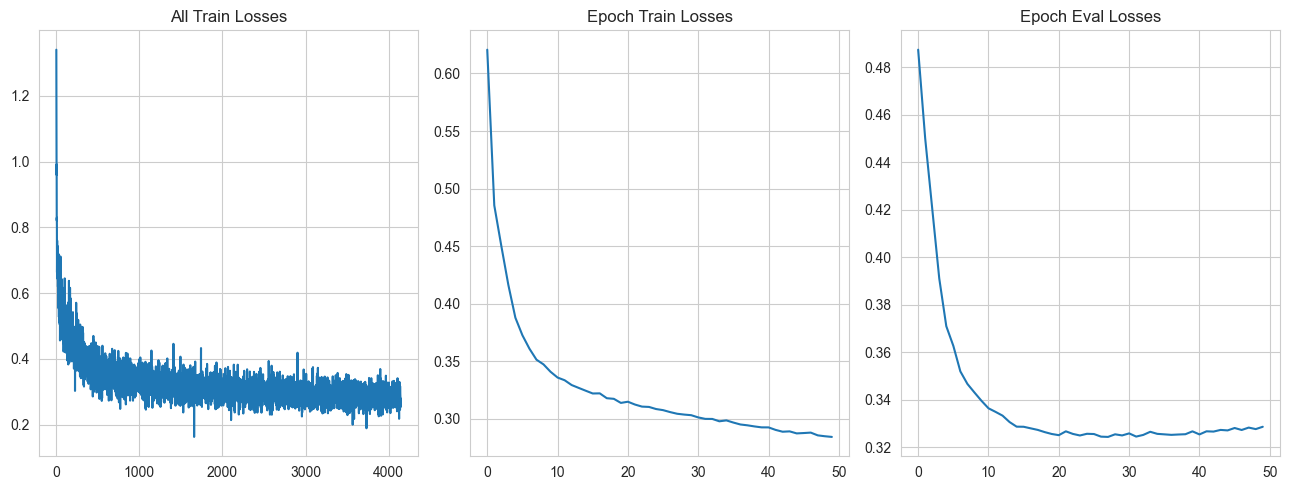

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(all_train_losses)
axes[0].set_title('All Train Losses')
axes[1].plot(train_losses)
axes[1].set_title('Epoch Train Losses')
axes[2].plot(test_losses)
axes[2].set_title('Epoch Eval Losses')
plt.tight_layout()
plt.show()

In [96]:
model = TransformerAE(input_dim=48, d_model=48, seq_length=31).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [97]:
epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in all_loader:
        
        batch = batch[0].unsqueeze(1).view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.7546
Epoch 2, Loss: 0.5704
Epoch 3, Loss: 0.5188
Epoch 4, Loss: 0.4791
Epoch 5, Loss: 0.4555
Epoch 6, Loss: 0.4413
Epoch 7, Loss: 0.4318
Epoch 8, Loss: 0.4238
Epoch 9, Loss: 0.4172
Epoch 10, Loss: 0.4119
Epoch 11, Loss: 0.4079
Epoch 12, Loss: 0.4049
Epoch 13, Loss: 0.4011
Epoch 14, Loss: 0.3986
Epoch 15, Loss: 0.3958
Epoch 16, Loss: 0.3933
Epoch 17, Loss: 0.3913
Epoch 18, Loss: 0.3893
Epoch 19, Loss: 0.3877
Epoch 20, Loss: 0.3868
Epoch 21, Loss: 0.3842
Epoch 22, Loss: 0.3823
Epoch 23, Loss: 0.3809
Epoch 24, Loss: 0.3791
Epoch 25, Loss: 0.3778


In [98]:
errors = []
encoded = []
reconstructed = []
with torch.no_grad():
    for sample in all_data:
        inputs = sample.view(-1, 31, 48).to(device)
        res = model(inputs).cpu().detach().flatten()
        reconstruction_error = criterion(res, sample)
        errors.append(reconstruction_error.cpu().detach().numpy())
        
        features = model.encode(inputs).view(-1)
        encoded.append(features.cpu().detach().numpy())
        
        reconstructed.append(res.view(-1).cpu().detach().numpy())
errors = np.array(errors)
encoded = np.array(encoded)
reconstructed = np.array(reconstructed)

In [99]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()

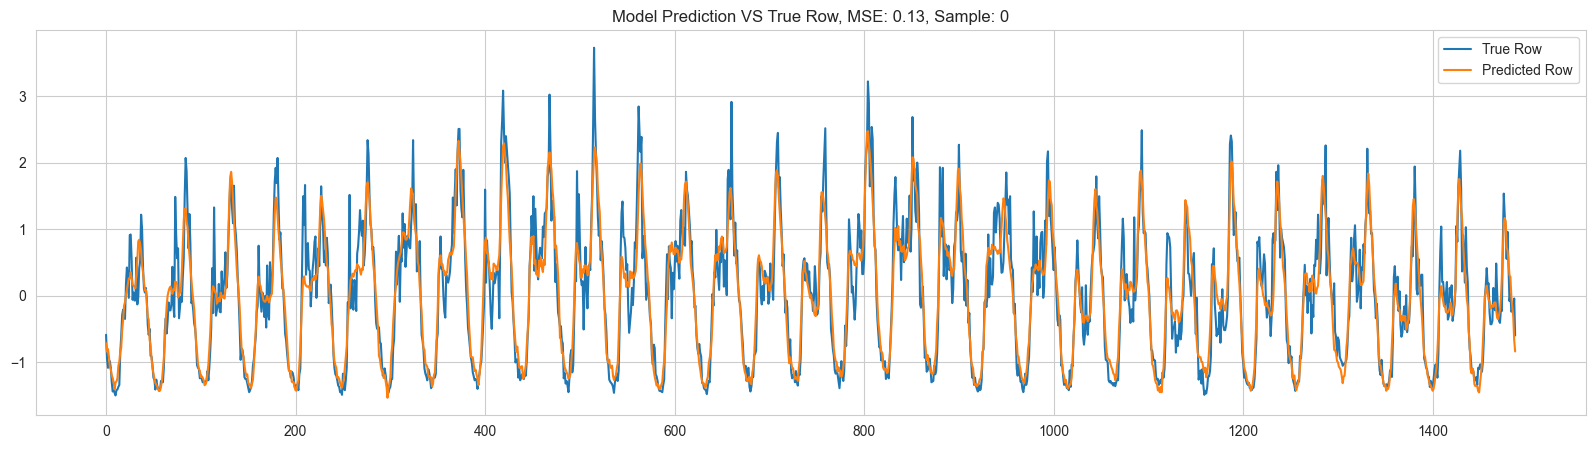

In [100]:
plot_sample(0)

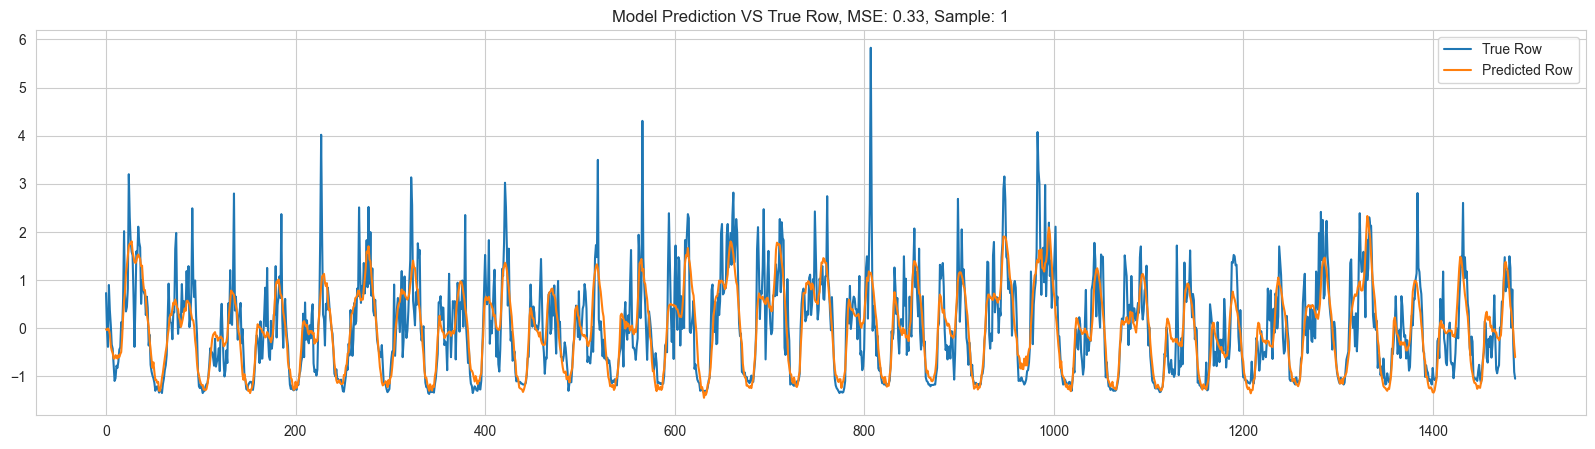

In [101]:
plot_sample(1)

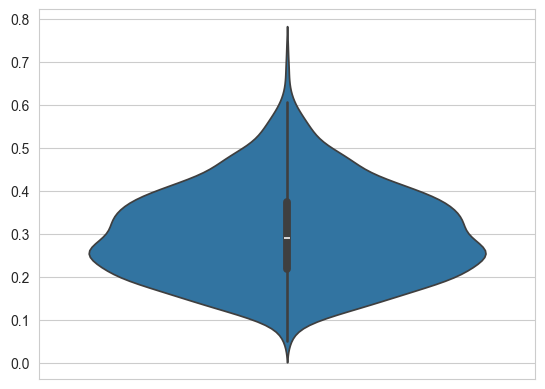

In [102]:
sns.violinplot(errors)
plt.show()

In [103]:
np.quantile(errors, 0.99)

0.5764500457048415

In [104]:
np.column_stack((np.argsort(-errors), -np.sort(-errors)))

array([[9.08000000e+02, 7.34015584e-01],
       [1.22500000e+03, 6.88881159e-01],
       [2.80000000e+01, 6.84937656e-01],
       ...,
       [1.10200000e+03, 6.30424917e-02],
       [6.54000000e+02, 5.73618300e-02],
       [2.23000000e+02, 5.02709001e-02]])

In [ ]:
# 908.0,0.734016
# 1225.0,0.688881
# 28.0,0.684938
# 142.0,0.646458
# 554.0,0.644761
# 1178.0,0.620851
# 393.0,0.611424
# 1578.0,0.610855
# 170.0,0.606696
# 446.0,0.602666

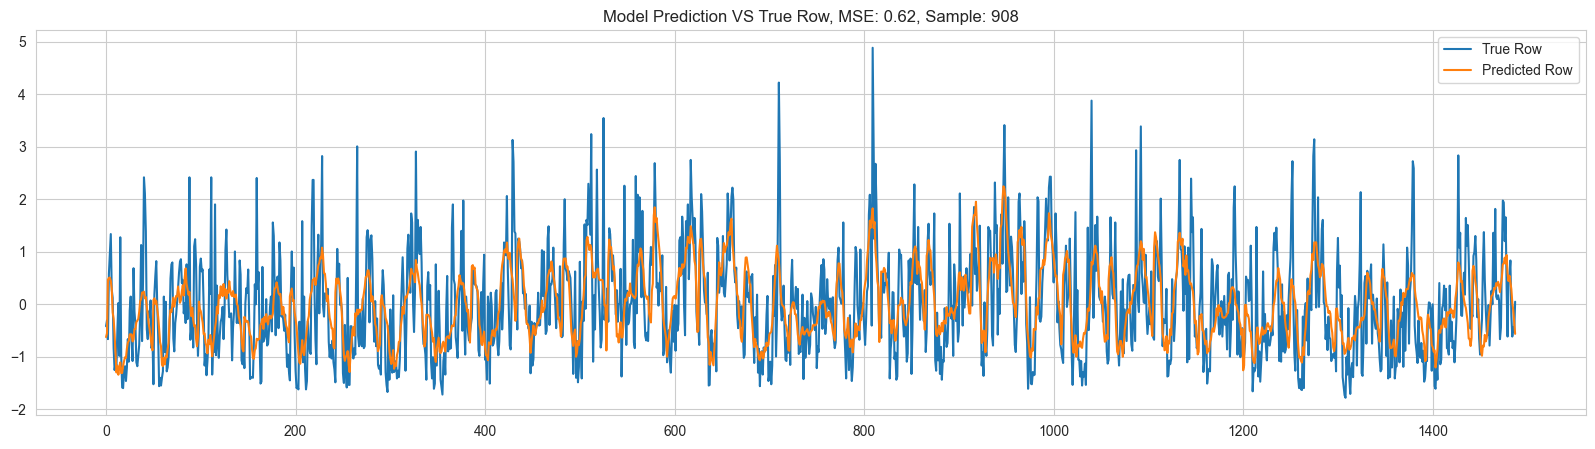

In [84]:
plot_sample(908)

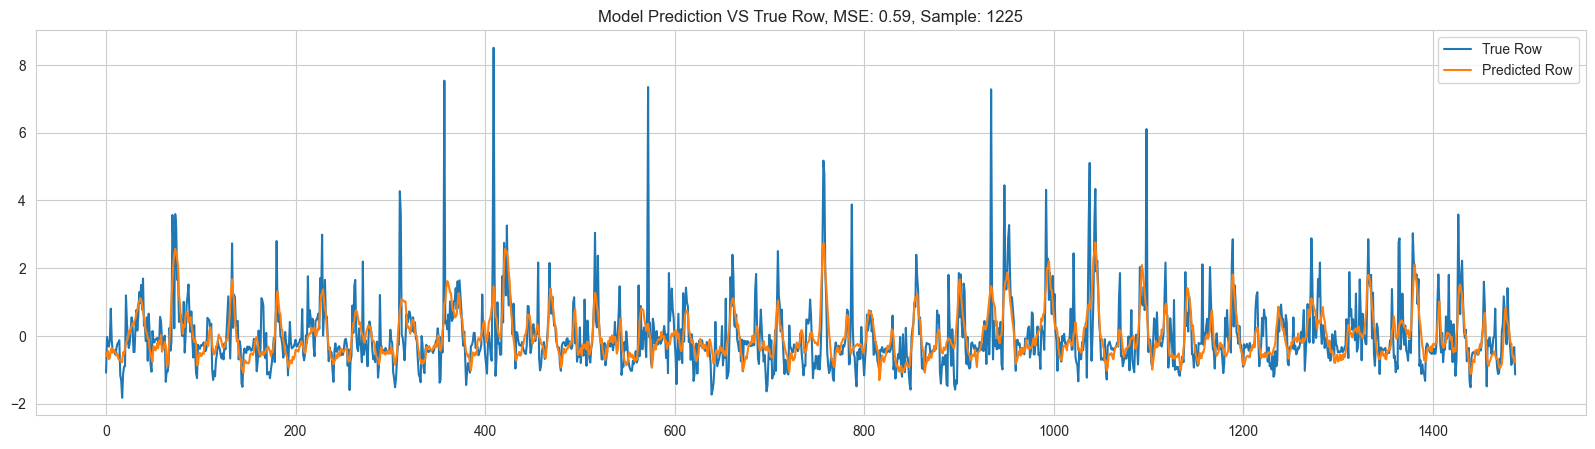

In [85]:
plot_sample(1225)

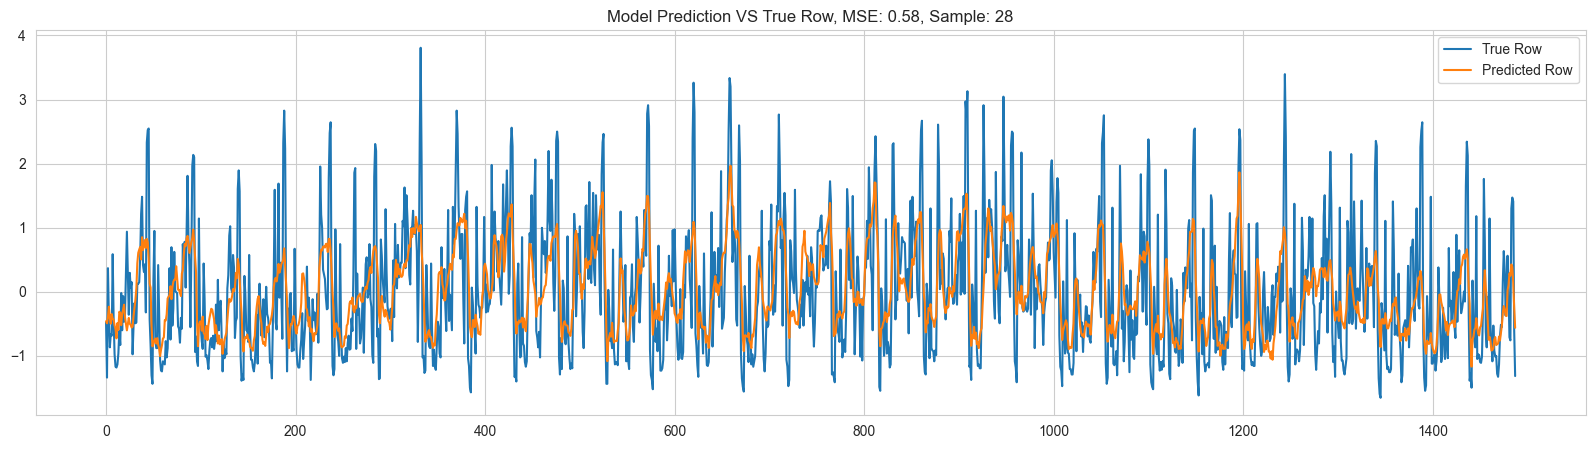

In [86]:
plot_sample(28)

In [89]:
# torch.save(model.state_dict(), './models/transformer_ae.pt')

In [105]:
encoded_norm = (encoded - encoded.mean(axis=0)) / encoded.std(axis=0)

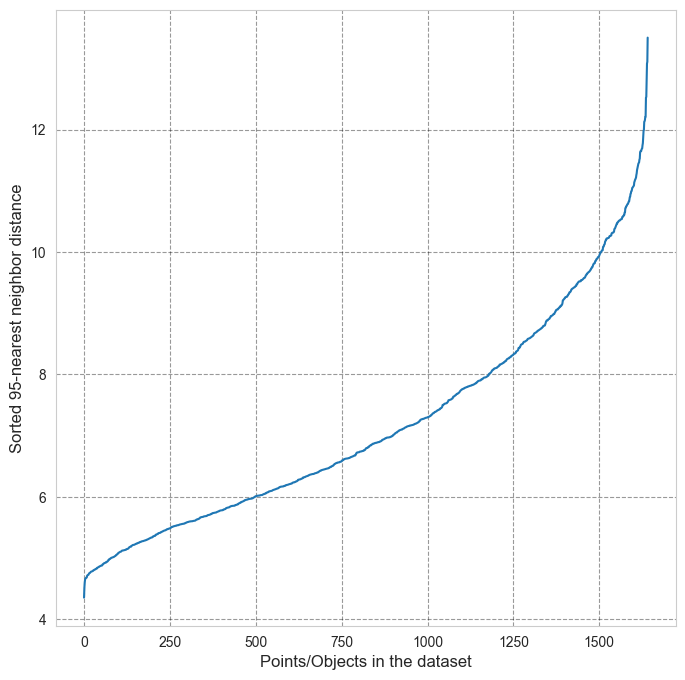

In [106]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_norm.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_norm, k=k)

In [113]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=10, min_samples=20)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_norm)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]
anomalies_indices

# 146, 1034, 1168

array([  56,  122,  394,  647,  950, 1168, 1416, 1435, 1437, 1486],
      dtype=int64)

In [ ]:
#  56,  122,  394,  647,  950, 1168, 1416, 1435, 1437, 1486

In [140]:
anomalies_indices.reshape(-1, 1)

array([[  56],
       [ 122],
       [ 146],
       [ 412],
       [ 543],
       [ 704],
       [ 950],
       [1034],
       [1119],
       [1168]], dtype=int64)

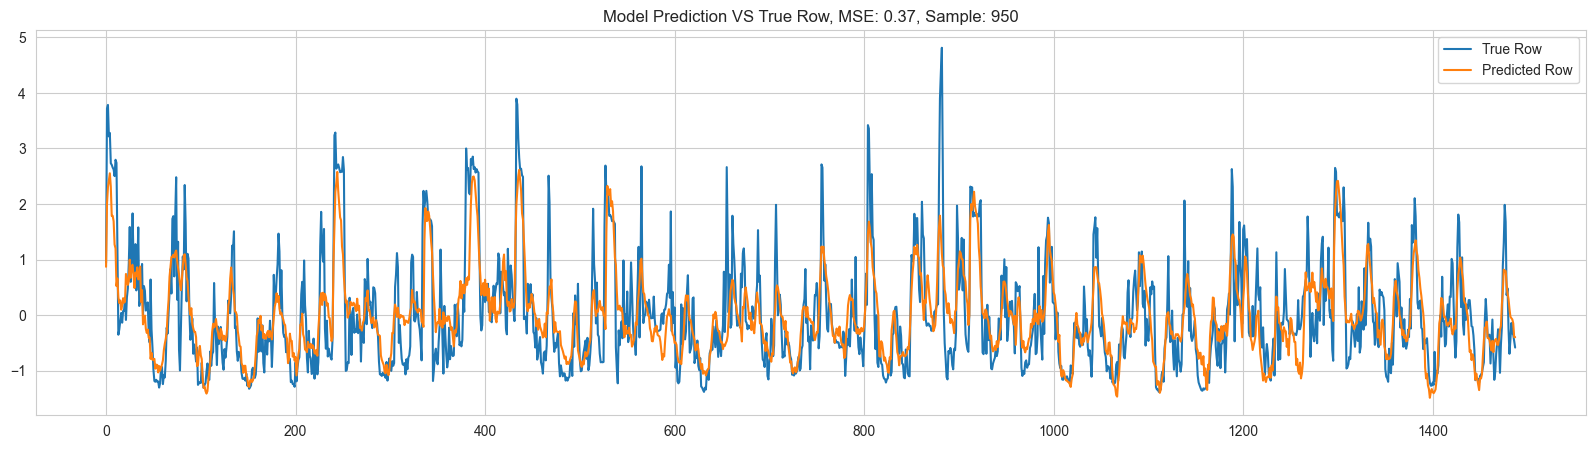

In [114]:
plot_sample(950)

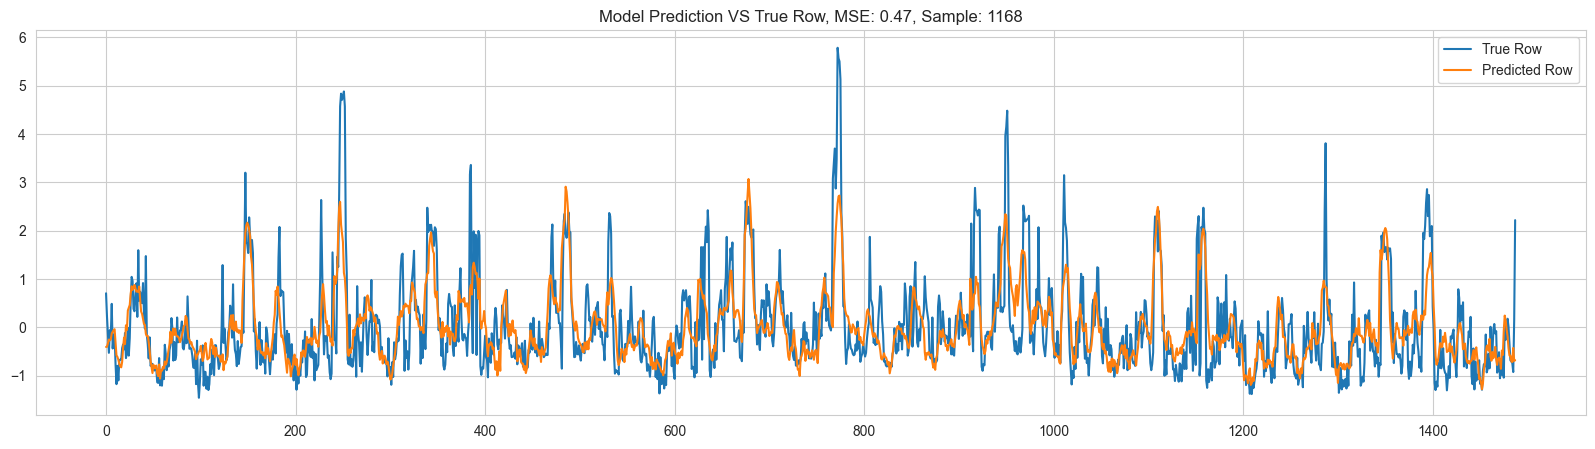

In [115]:
plot_sample(1168)

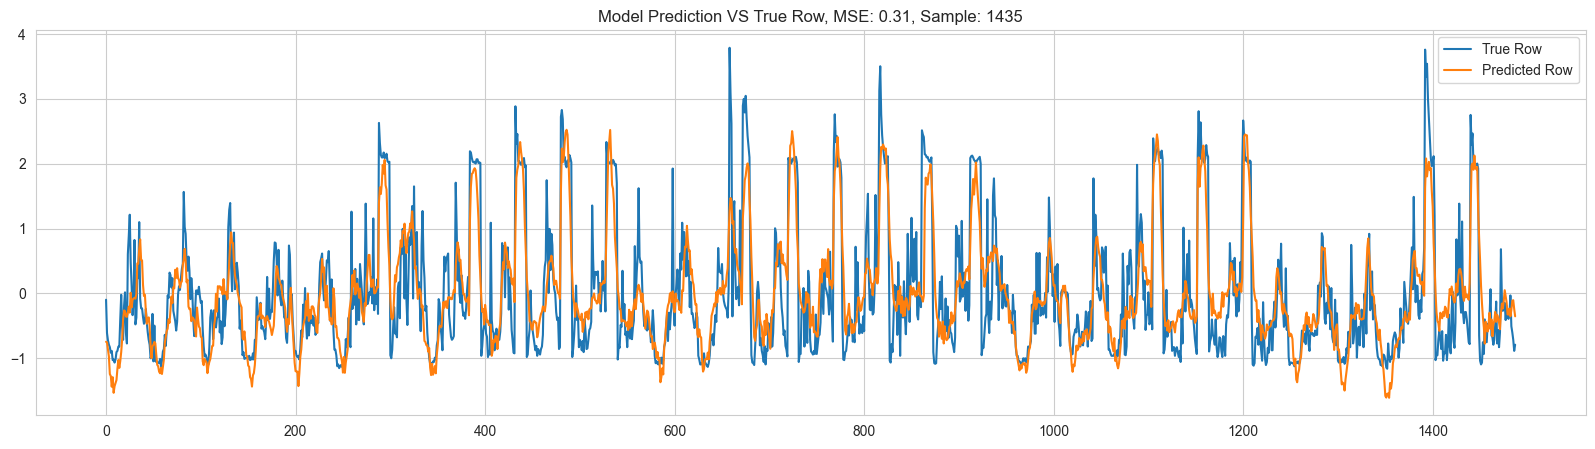

In [116]:
plot_sample(1435)

In [125]:
arr = [394,1034,142,383,380,908,584,787,339,1225,1225,28,908,554,1034,142,
       1578,1178,1146,948,1578,394,1168,412,142,950,122,1034,170,488,908,1225,
       28,142,554,1178,393,1578,170,446,4,146,393,412,603,693,950,1167,1416,1443,
       56,146,528,704,950,1014,1119,1168,1416,1486,28,462,528,677,921,936,1014,1018,
       1189,1486,56,122,394,647,950,1168,1416,1435,1437,1486]

np.vstack(np.unique(arr, return_counts=True)).T

array([[   4,    1],
       [  28,    3],
       [  56,    2],
       [ 122,    2],
       [ 142,    4],
       [ 146,    2],
       [ 170,    2],
       [ 339,    1],
       [ 380,    1],
       [ 383,    1],
       [ 393,    2],
       [ 394,    3],
       [ 412,    2],
       [ 446,    1],
       [ 462,    1],
       [ 488,    1],
       [ 528,    2],
       [ 554,    2],
       [ 584,    1],
       [ 603,    1],
       [ 647,    1],
       [ 677,    1],
       [ 693,    1],
       [ 704,    1],
       [ 787,    1],
       [ 908,    3],
       [ 921,    1],
       [ 936,    1],
       [ 948,    1],
       [ 950,    4],
       [1014,    2],
       [1018,    1],
       [1034,    3],
       [1119,    1],
       [1146,    1],
       [1167,    1],
       [1168,    3],
       [1178,    2],
       [1189,    1],
       [1225,    3],
       [1416,    3],
       [1435,    1],
       [1437,    1],
       [1443,    1],
       [1486,    3],
       [1578,    3]], dtype=int64)

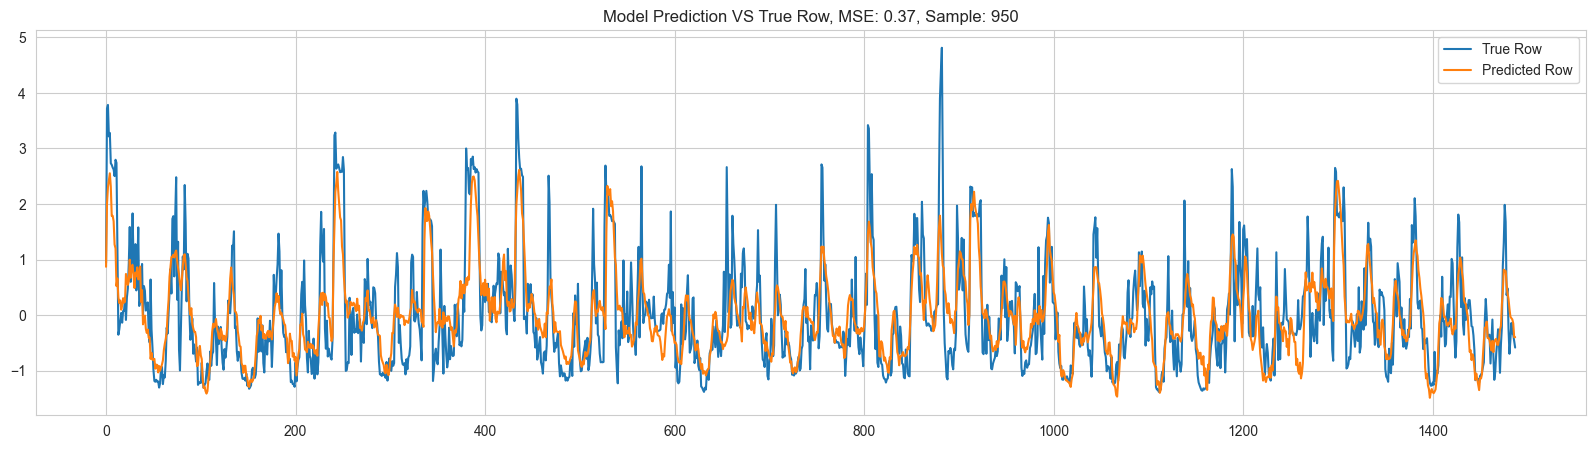

In [127]:
plot_sample(950)

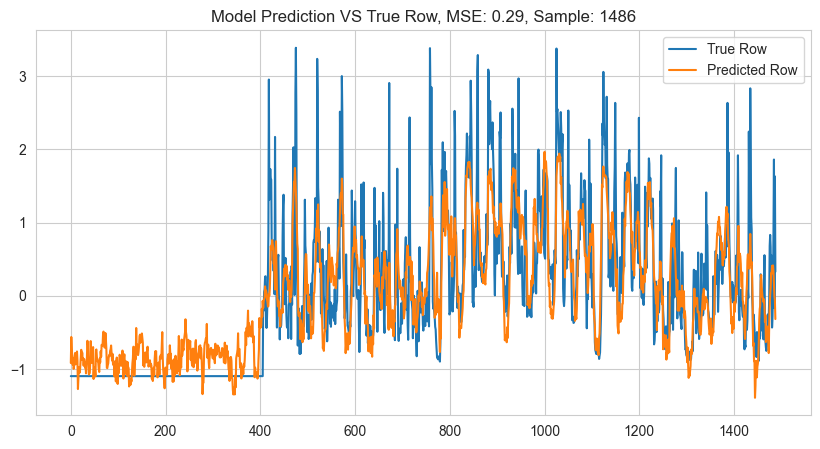

In [149]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()
plot_sample(1486)